<a href="https://colab.research.google.com/github/Evaggelou/Arvato-Project-/blob/main/Arvato_Project_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# magic word for producing visualizations in notebook
%matplotlib inline

Mounted at /content/drive


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato//Udacity_CUSTOMERS_052018.csv', sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Ignore any empty columns while loading data
no_unamed = lambda x: 'Unnamed' not in x

attributes = pd.read_excel('/content/drive/MyDrive/Udacity/Arvato/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
attributes_info = pd.read_excel('/content/drive/MyDrive/Udacity/Arvato/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)

#### Find the excpected values for each feature
We can find from the "DIAS Attributes - Values 2017.xlsx" schema file what are the expected values foe each feature.

In [ ]:
def find_attributes_names_values(attributes):
    """
    Description:
        Find the expected values for each feature according to the schema
    INPUT:
    attributes - (pandas dataframe) with detailed mapping of data values for each feature
    OUTPUT:
    attributes_names_values - a dataframe where at first column is name for each feature and
    at the second the expected value  
    """
    attr_name=[]
    attr_values=[]
    attr_values_temp=[]
    i=-1
    for j in range(len(attributes)):
        if attributes.iloc[j].Attribute == attributes.iloc[j].Attribute:
            attr_name.append(attributes.iloc[j].Attribute)
            if j!=0:
                attr_values.append(attr_values_temp)
            attr_values_temp=[] 
        attr_values_temp.append(attributes.iloc[j].Value)
    attr_values.append(attr_values_temp)

    attributes_names_values = pd.DataFrame({'attr_name':attr_name,'attr_values':attr_values})

    return attributes_names_values

In [ ]:
attributes_names_values = find_attributes_names_values(attributes)
attributes_names_values.head()

,attr_name,attr_values
0,AGER_TYP,"[-1, 0, 1, 2, 3]"
1,ALTERSKATEGORIE_GROB,"[-1, 0, 1, 2, 3, 4, 9]"
2,ALTER_HH,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,ANREDE_KZ,"[-1, 0, 1, 2]"
4,ANZ_HAUSHALTE_AKTIV,[…]


### 0.1 Explore the 2 main files Udacity_AZDIAS_052018.csv and Udacity_CUSTOMERS_052018.csv

#### 0.1.1 Check values at the Udacity_AZDIAS_052018.csv file

In [ ]:
print(f"azdias shape: {azdias.shape}")
azdias.head()

azdias shape: (891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,12,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,43,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [ ]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,794005.000000,797481.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,770025.000000,794005.00000,886367.000000,886367.000000,886367.000000,839995.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,793947.000000,817722.000000,793435.000000,793435.000000,817722.000000,793947.00000,891221.000000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,3.167854,4.153043,3.632838,3.335264,3.368086,3.195014,3.351290,3.336151,3.360684,3.465980,0.122336,0.219907,9.267420,0.892735,0.568580,0.106769,9.926794,9.439073,0.705221,0.425645,0.467869,1.145516,0.485508,0.257938,1.585405,...,4.257967,3.07222,3.419630,3.233723,3.863797,3.023813,4.667550,4.481405,4.272729,4.445007,4.763223,4.025014,4.359086,4.001597,4.256076,3.910139,4.240609,3.945860,3.661784,4.023709,1.266967,0.008423,2.539212,0.003483,3.223125,4.017526,0.090067,4.58576,1.197852,0.43882,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,0.324028,0.502389,1.155849,14.332201,0.068855,1.002376,2.183710,1.595021,1.493633,1.368331,1.401382,1.396508,1.373077,1.378992,1.328456,0.535950,0.747903,1.735725,2.011838,1.643764,0.808179,0.605641,1.547773,2.552707,1.510782,1.542151,2.266999,1.639340,1.252328,2.547925,...,2.030385,1.36298,1.417741,1.388687,1.282747,1.502725,1.795712,1.807552,1.915885,1.852412,1.830789,1.903816,2.022829,1.857540,1.770137,1.580306,2.007373,1.946564,1.707637,2.077746,1.287435,0.091392,0.754926,0.084957,1.255785,1.118399,0.286278,8.47152,0.952532,1.14329,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00

In [ ]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


When we read the file we have a DtypeWarning about the columns 18 and 19. 
Let's explore them:

In [ ]:
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [ ]:
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [ ]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

We have both int and float type and 'X' at CAMEO_DEUG_2015 and 'XX' at CAMEO_INTL_2015. So we have to convert all the values to float and nan accordingly

In [ ]:
def fix_CAMEO_columns(df):
    """
    Description:
        Convert int values to float at features CAMEO_DEUG_2015, CAMEO_INTL_2015
        Replace X and XX with -1
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    df - dataframe with fixed features   
    """
    
    if 'X' in df['CAMEO_DEUG_2015'].unique():
        df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan})
    
    if 'XX' in df['CAMEO_INTL_2015'].unique():
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})

    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    return df

# azdias = fix_CAMEO_columns(azdias)

In [ ]:
# check columns
print(f"CAMEO_DEUG_2015 : {azdias.CAMEO_DEUG_2015.unique()}")
print(f"CAMEO_INTL_2015 : {azdias.CAMEO_INTL_2015.unique()}")

CAMEO_DEUG_2015 : [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 : [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


#### 0.1.2 Check values at the Udacity_CUSTOMERS_052018.csv file

In [ ]:
print(f"customers shape: {customers.shape}")
customers.head()

customers shape: (191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1,13,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,...,NaN,NaN,NaN,3,3,6,2,3,4,5,6,4,1,2,3,1,7,3,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,1.0,5,7,2,6,7,1,7,3,4,2,1,2,1,3,1,0.0,3.0,0.0,1.0,5.0,0.0,0.0,2,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,4C,4,24,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,2.0,3,3,5,3,3,4,5,4,3,3,3,6,4,7,0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,1,0.0,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7B,7,41,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1,2,3,5,0,3,10,7,0.0,0,0,6,...,4.0,3.0,5.0,5,4,5,2,3,5,6,6,5,5,4,4,4,5,1,0.0,3.0,0.0,2.0,4.0,0.0,1.0,2,0.0,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [ ]:
# customers = fix_CAMEO_columns(customers)

### Mising Values

In [ ]:
attributes_unknown

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [ ]:
attributes_unknown = attributes[attributes.Meaning == "unknown"]
attributes_unknown.dropna(subset = ["Attribute"], inplace=True)
print(f"Number of attributes with Unknown meaning: {len(attributes_unknown)}")

def replace_nan(df, attributes_unknown):
    '''
    Description: Replace unknown values with np.nan
    '''
    for attr in attributes_unknown.Attribute:
        if attr in df.columns:
            unknown = attributes_unknown[attributes_unknown.Attribute==attr].Value.values[0]

            if type(unknown)==str:
                unknown = list(map(int, unknown.split(",")))
            
            df[attr].replace(unknown, np.nan, inplace=True)
    return df

customers = replace_nan(customers, attributes_unknown)
azdias = replace_nan(azdias, attributes_unknown)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Number of attributes with Unknown meaning: 230


#### Find how many are the missing values at every Column

Text(0, 0.5, 'Percentage')

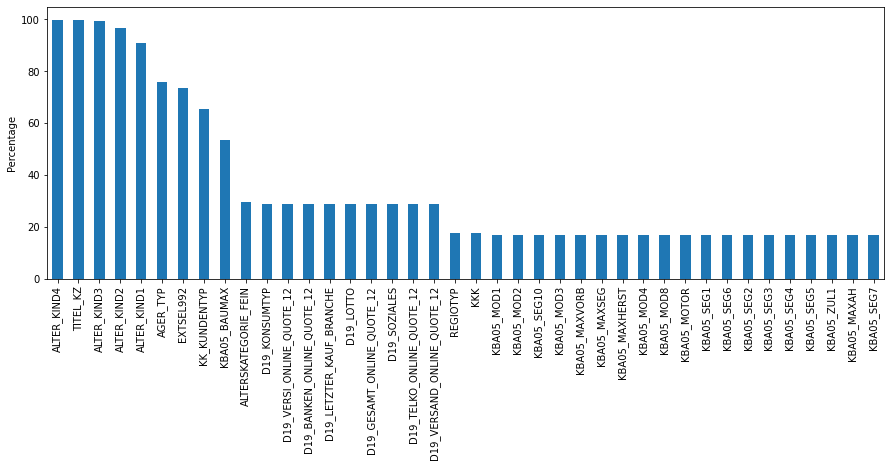

In [ ]:
missing_values = (np.sum(azdias.isnull(),axis=0)*100/azdias.shape[0]).sort_values(ascending=False)

missing_values[:40].plot(figsize = (15,5), kind='bar')
plt.ylabel("Percentage")

Text(0, 0.5, '# of features')

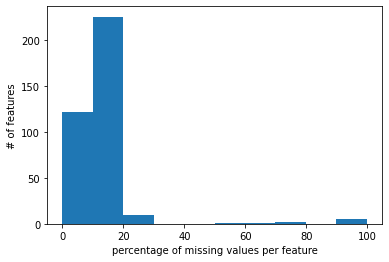

In [ ]:
plt.hist(missing_values)
plt.xlabel("percentage of missing values per feature")
plt.ylabel("# of features")

With the above plots we can see that the most features have less than 20% missing values and we have some features with more than 80% so I will remove the features that have more than 35% missing values.

In [ ]:
def drop_columns(df, threshold=0.35):
    """
    Description:
        Drop columns with more than 35% null values (calculated from the population dataset)
    """
    
    columns_to_drop = [r for r, b in (df.isnull().sum() > df.shape[0] * threshold).items() if b]

    df = df.drop(columns_to_drop, axis=1)
    print(f"# of dropped columns: {len(columns_to_drop)}")
    
    return df

# azdias = drop_columns(azdias)
# customers = drop_columns(customers)

#### Find missing values per Row

We should check what is the mean percentage of missing values per subject (row) and find out if we have to remove some of the rows due to missing of informations about them.

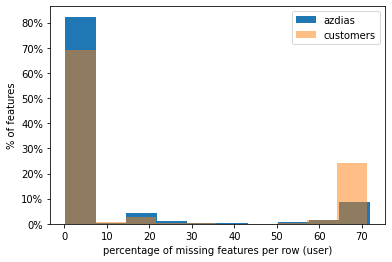

In [ ]:
missing_rows_azdias = (np.sum(azdias.isnull(),axis=1)*100/azdias.shape[1]).sort_values(ascending=False)
missing_rows_customers = (np.sum(customers.isnull(),axis=1)*100/customers.shape[1]).sort_values(ascending=False)

from matplotlib.ticker import PercentFormatter

plt.hist(missing_rows_azdias,weights=np.ones(len(missing_rows_azdias)) / len(missing_rows_azdias),label="azdias")
plt.hist(missing_rows_customers,weights=np.ones(len(missing_rows_customers)) / len(missing_rows_customers), \
         label='customers', alpha=0.5)

plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("percentage of missing features per row (user)")
plt.ylabel("% of features")
plt.show()

We can clearly see that the most of the users have more than 50% of the feauters

In [ ]:
def drop_rows_missing_values(df, threshold=0.5):
    """
        Drop rows with more than 50 null values
    INPUT:
        df : population or customer dataframe
    
    OUTPUT:
        df : cleared dataframe
    """
    df = df[df.isnull().sum(axis=1)<0.5*df.shape[1]]
    return df

# customers = drop_rows_missing_values(customers)
# azdias = drop_rows_missing_values(azdias)

### Check for different types

In [ ]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [ ]:
# Explore all the unique values that a feature have and it's description
unique_azdias_per_col=[]
for col in azdias:
    print(f"{col}")
    print(f"Description: {list(attributes[attributes.Attribute==col].Description)}")
    print(f"Unique values:{azdias[col].unique()}, Type: {azdias[col].dtypes}\n")
    unique_azdias_per_col.append(azdias[col].unique())

LNR
Description: []
Unique values:[910215 910220 910225 ... 825772 825776 825787], Type: int64

AGER_TYP
Description: ['best-ager typology']
Unique values:[-1  2  3  0  1], Type: int64

AKT_DAT_KL
Description: []
Unique values:[nan  9.  1.  5.  8.  7.  6.  4.  3.  2.], Type: float64

ALTER_HH
Description: ['main age within the household']
Unique values:[nan  0. 17. 13. 20. 10. 14. 16. 21. 11. 19. 15.  9. 18.  8.  7. 12.  4.
  3.  6.  5.  2.  1.], Type: float64

ALTER_KIND1
Description: []
Unique values:[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.], Type: float64

ALTER_KIND2
Description: []
Unique values:[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.], Type: float64

ALTER_KIND3
Description: []
Unique values:[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.], Type: float64

ALTER_KIND4
Description: []
Unique values:[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.], Type: float64

ALTERSKATEGORIE_FEIN
Description: 

#### Find columns that are as 'object' type

In [ ]:
azdias[azdias.dtypes[azdias.dtypes=='object'].index]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [ ]:
def find_object_col(df):
    object_col = df.columns[df.dtypes == "object"]
    return object_col

# print(find_object_col(azdias))
# print(find_object_col(customers))

In [ ]:
def object_type_col(df):

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"]).dt.year
    df = pd.get_dummies(df, columns=['D19_LETZTER_KAUF_BRANCHE'])
    df = df.drop(['CAMEO_DEU_2015','LNR'], axis = 1)
    
    return df

# azdias = object_type_col(azdias)
# customers = object_type_col(customers)

In [ ]:
def convert_int_to_float(df):
    '''
    Description
    Convert int values to float
    '''
    int_col = df.select_dtypes(include=['uint8','int']).columns
    df[int_col] = df[int_col].astype(float)
    return df

# azdias = convert_int_to_float(azdias)
# customers = convert_int_to_float(customers)

In [ ]:
# Explore all the unique values that a feature have and it's description
for col in customers:
    print(f"{col}")
    print(f"Description: {list(attributes[attributes.Attribute==col].Description)}")
    print(f"Unique values:{customers[col].unique()}, Type: {customers[col].dtypes}\n")


LNR
Description: []
Unique values:[  9626   9628 143872 ... 148813 148852 148883], Type: int64

AGER_TYP
Description: ['best-ager typology']
Unique values:[ 2 -1  1  0  3], Type: int64

AKT_DAT_KL
Description: []
Unique values:[ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.], Type: float64

ALTER_HH
Description: ['main age within the household']
Unique values:[10. 11.  6.  8. 20.  5. 14. 21. 15. 17.  0. 19.  9. 12. 13. nan 18.  7.
 16.  4.  2.  3.], Type: float64

ALTER_KIND1
Description: []
Unique values:[nan  8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.], Type: float64

ALTER_KIND2
Description: []
Unique values:[nan  9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.], Type: float64

ALTER_KIND3
Description: []
Unique values:[nan 13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.], Type: float64

ALTER_KIND4
Description: []
Unique values:[nan 18. 12. 16. 13. 17. 11. 14. 15. 10.  8.], Type: float64

ALTERSKATEGORIE_FEIN
Description: []
Unique values

In [ ]:
# find the difference in spreadsheet and in the population
atributes_list = attributes.Attribute.unique().tolist()
azdias_list = azdias.columns.unique().tolist()
print("Common:")
print(f"Both in spreadsheet and in the population: {len(np.intersect1d(azdias_list,atributes_list))}")
print("\nDifferences:")
print(f"In population and not in the spreadsheet: {len(np.setdiff1d(azdias_list,atributes_list))}")
print(f"In spreadsheet and not in the population: {len(np.setdiff1d(atributes_list,azdias_list))}")

Common:
Both in spreadsheet and in the population: 272

Differences:
In population and not in the spreadsheet: 94
In spreadsheet and not in the population: 43


### Clean data pipeline

In [ ]:
def clean_data(df):
    print("Clean dataframe")

    # azdias = fix_CAMEO_columns(azdias)
    print("Remove columns with missing values more than 35%")
    df = fix_CAMEO_columns(df)

    attributes_unknown = attributes[attributes.Meaning == "unknown"]
    attributes_unknown.dropna(subset = ["Attribute"], inplace=True)
    df = replace_nan(df, attributes_unknown)

    print("Remove columns with missing values more than 30%")
    df = drop_columns(df)
    
    print(f"Remove rows with missing values more than 50%")
    df =  drop_rows_missing_values(df)

    df = object_type_col(df)
    df = convert_int_to_float(df)

    return df

In [ ]:
%%time
azdias = clean_data(azdias)

Clean dataframe
Remove columns with missing values more than 35%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Remove columns with missing values more than 30%
# of dropped columns: 9
Remove rows with missing values more than 50%
CPU times: user 9.68 s, sys: 1.02 s, total: 10.7 s
Wall time: 10.7 s


In [ ]:
%%time
customers = clean_data(customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1))

Clean dataframe
Remove columns with missing values more than 35%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Remove columns with missing values more than 30%
# of dropped columns: 9
Remove rows with missing values more than 50%
CPU times: user 2.39 s, sys: 98.2 ms, total: 2.49 s
Wall time: 2.49 s


### Fill nan values as -1

In [ ]:
#merge_data=merge_data.fillna(merge_data.mean())
azdias=azdias.fillna(-1)

In [ ]:
customers=customers.fillna(-1)

In [ ]:
# Dump the dataframes to  pickle object .
pickle.dump(azdias, open("/content/drive/MyDrive/Udacity/Arvato/azdias_cleaned.pickle", "wb"))
pickle.dump(customers, open("/content/drive/MyDrive/Udacity/Arvato/customers_cleaned.pickle", "wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
# load pickle objects
azdias = pickle.load(open("/content/drive/MyDrive/Udacity/Arvato/azdias_cleaned.pickle", "rb"))
customers = pickle.load(open("/content/drive/MyDrive/Udacity/Arvato/customers_cleaned.pickle", "rb"))

In [ ]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE,D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE_D19_LOTTO,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,4.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,9.0,7.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,5.0,1.0,2.0,0.0,10.0,5.0,10.0,6.0,6.0,1.0,6.0,0.0,6.0,0.0,1.0,5.0,0.0,...,9.0,3.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,8.0,54.0,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,9.0,7.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

Normalization

In [ ]:
def Standirize_data(df):
    scaler = StandardScaler()
    df_values =df.values
    scaler.fit(df_values)
    df_scaled=scaler.transform(df_values)
    return df_scaled

In [ ]:
scaled_azdias = Standirize_data(azdias)
scaled_customers = scaler.transform(customers)

### Dimension reduction


#### PCA 

CPU times: user 1min 35s, sys: 21.2 s, total: 1min 56s
Wall time: 33.6 s


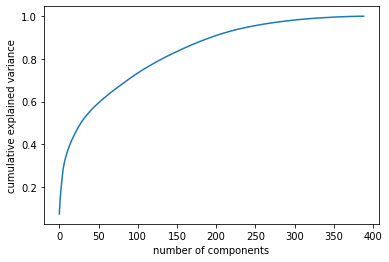

In [ ]:
%%time
pca = PCA().fit(scaled_azdias)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

~95% of variance is explained by first 250 components of pca

(791261, 389)
(791261, 3)


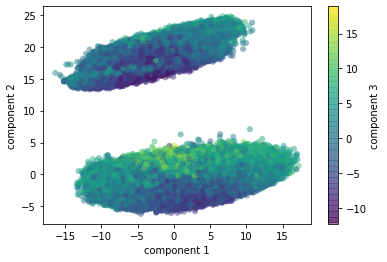

In [ ]:
pca = PCA(3)  # project from 64 to 2 dimensions
projected = pca.fit_transform(scaled_azdias)
print(scaled_azdias.shape)
print(projected.shape)

plt.scatter(projected[:, 0], projected[:, 1],
            c=projected[:, 2], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='component 3');

In [ ]:
# #When choose a large number of the principle components, it takes very long time to fitting. Here I set the n_components as 10.
# pca = PCA(n_components=10)
# dataset = pca.fit_transform(x_scaled)

# # Defining Model
# model = TSNE(learning_rate=100)

# # Fitting Model
# transformed = model.fit_transform(dataset)
# # Plotting 2d t-Sne
# x_axis = transformed[:, 0]
# y_axis = transformed[:, 1]
# plt.figure(figsize=(10,10))
# plt.scatter(x_axis, y_axis, c=label.values,s=1)
# plt.show()

In [ ]:
def PCA_data(data,n_components=200):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
pca_anzias = PCA_data(azdias_scaled)
pca_customers = PCA_data(customers_scaled)

##### plot PCA weights

In [ ]:
def weights_PCA(pc,weight_num):
    '''
    Description:
        plot the highest positive nad negative pc weights
    '''    
    variance_ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['Exp_Var']).round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values).round(3) 
    
    ratio_weights = pd.concat([variance_ratio, weights], axis = 1)
    
    pos = ratio_weights.iloc[(pc)-1].sort_values(ascending=False)[:weight_num]
    neg = ratio_weights.iloc[(pc)-1].sort_values()[:weight_num]

    print(f"Principal Component: {pc}\n")    
    print(f"Highest Positive weights:\n{pos}")
    print(f"Negative weights:\n{neg}")

    pd.concat([pos,neg]).plot(kind='bar',figsize=(10,5))
    plt.title(f"Principal Component {pc}\n Highest positive and negative weights")
    plt.show()

Principal Component: 0

Highest Positive weights:
KBA13_FAB_SONSTIGE                            0.707
D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST    0.000
KBA05_HERST5                                  0.000
KBA05_CCM3                                    0.000
KBA05_CCM4                                   -0.000
Name: 388, dtype: float64
Negative weights:
KBA13_HERST_SONST   -0.707
Exp_Var              0.000
KBA13_PEUGEOT       -0.000
KBA13_OPEL          -0.000
KBA13_NISSAN         0.000
Name: 388, dtype: float64


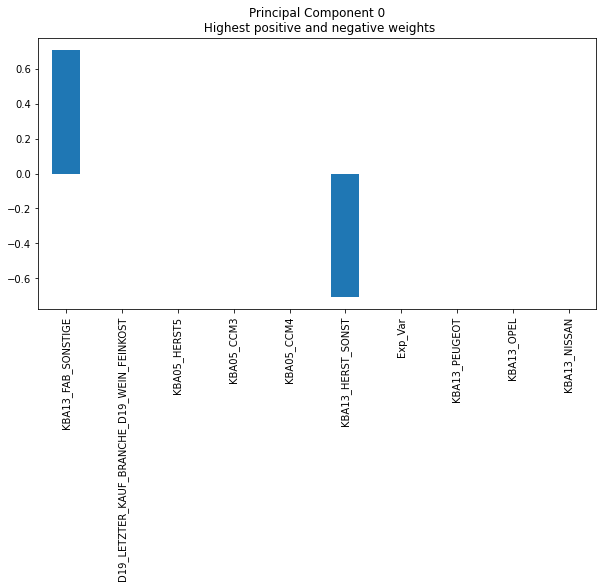

Principal Component: 1

Highest Positive weights:
LP_STATUS_FEIN    0.120
KBA13_ANTG1       0.119
MOBI_RASTER       0.117
LP_STATUS_GROB    0.117
MOBI_REGIO        0.117
Name: 0, dtype: float64
Negative weights:
HH_EINKOMMEN_SCORE   -0.117
D19_GESAMT_DATUM     -0.116
VK_DHT4A             -0.116
VK_DISTANZ           -0.114
CAMEO_DEUG_2015      -0.114
Name: 0, dtype: float64


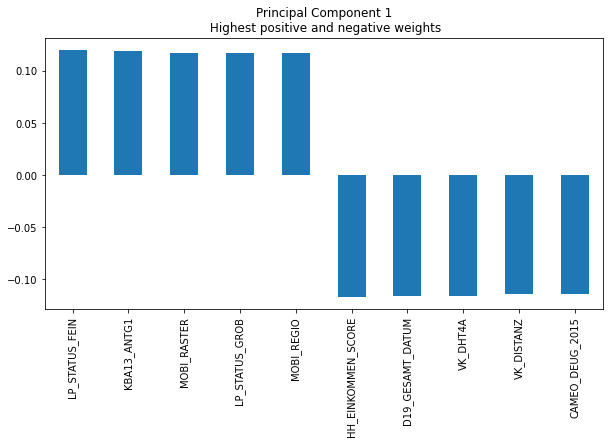

Principal Component: 2

Highest Positive weights:
EINGEFUEGT_AM       0.137
MIN_GEBAEUDEJAHR    0.131
KBA05_MODTEMP       0.085
Exp_Var             0.064
KBA05_HERSTTEMP     0.046
Name: 1, dtype: float64
Negative weights:
KBA05_KRSOBER    -0.155
KBA05_KRSVAN     -0.155
KBA05_KRSZUL     -0.145
KBA05_KRSKLEIN   -0.143
KBA05_MOTOR      -0.143
Name: 1, dtype: float64


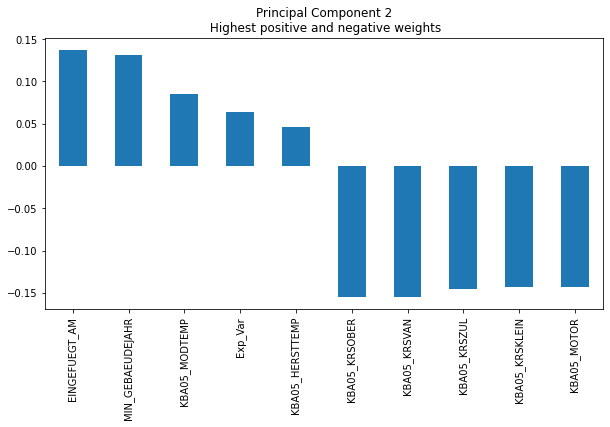

Principal Component: 3

Highest Positive weights:
CJT_TYP_2                0.146
PRAEGENDE_JUGENDJAHRE    0.146
FINANZ_SPARER            0.143
ONLINE_AFFINITAET        0.140
CJT_TYP_1                0.138
Name: 2, dtype: float64
Negative weights:
CJT_TYP_5          -0.142
CJT_TYP_3          -0.137
CJT_TYP_6          -0.133
CJT_TYP_4          -0.133
FINANZ_VORSORGER   -0.130
Name: 2, dtype: float64


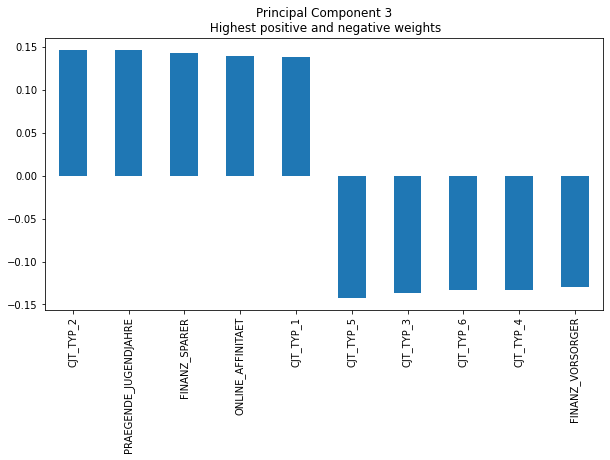

Principal Component: 4

Highest Positive weights:
KBA13_HERST_BMW_BENZ           0.197
KBA13_MERCEDES                 0.170
KBA13_SEG_OBEREMITTELKLASSE    0.168
KBA13_BMW                      0.164
KBA13_SEG_SPORTWAGEN           0.157
Name: 3, dtype: float64
Negative weights:
KBA13_SITZE_5          -0.156
KBA13_KMH_140_210      -0.135
KBA13_SEG_KLEINWAGEN   -0.134
KBA13_HALTER_25        -0.124
KBA13_KMH_180          -0.123
Name: 3, dtype: float64


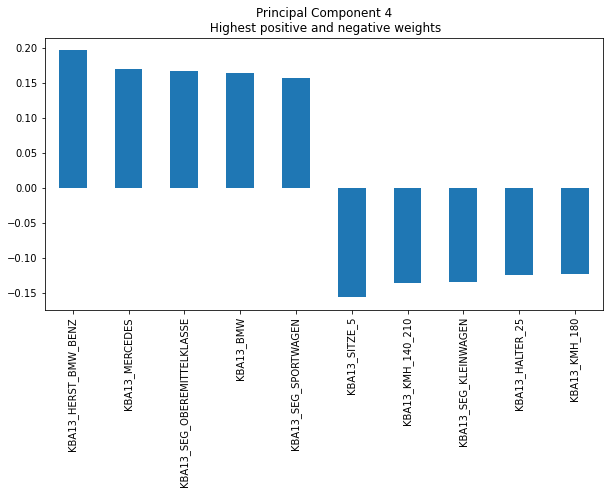

In [ ]:
for i in range(5):
    weights_PCA(i,5)

In [ ]:
azdias["v"].value_counts()

 3.0    345124
 2.0    167481
 4.0    153466
 5.0     61004
 1.0     58346
-1.0      5840
Name: KBA13_FAB_SONSTIGE, dtype: int64

In [ ]:
azdias["KBA13_HERST_SONST"].value_counts()

 3.0    345124
 2.0    167481
 4.0    153466
 5.0     61004
 1.0     58346
-1.0      5840
Name: KBA13_HERST_SONST, dtype: int64

### Kmeans Clustering

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
# K = range(1, 20)
X=pca_anzias

for k in trange(1, 20):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 18.28158260073479
2 : 17.728435764093373
3 : 17.197651445258973
4 : 16.905755652532356
5 : 16.704298379044737
6 : 16.5497125636772
7 : 16.420414094121277
8 : 16.318958765977605
9 : 16.232728453064624
10 : 16.164356877549857
11 : 16.082798854704972
12 : 16.02949340392225
13 : 15.982688585541283
14 : 15.925491219281733
15 : 15.884030135911061
16 : 15.847975823820436
17 : 15.797223604130629
18 : 15.76656410602643
19 : 15.741178133576843


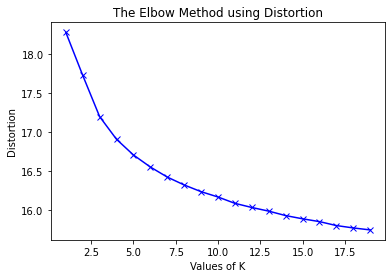

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 279207286.5747839
2 : 260394627.4125628
3 : 245511422.9716402
4 : 237778843.37436795
5 : 229383023.92009443
6 : 225541585.73265716
7 : 222179108.8401024
8 : 219516904.9197237
9 : 217197548.84980947
10 : 215443150.07191926
11 : 213359636.5250887
12 : 211867047.4780539
13 : 210642803.31567544
14 : 209217298.57859212
15 : 208155770.36272863
16 : 207242054.5724729
17 : 206052204.7610948
18 : 205301753.2102158
19 : 204671825.29279974


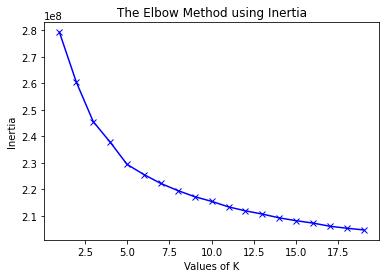

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
n_clusters=9

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# apply kmeans with 9 clusters for the general population
kmeans_model = kmeans.fit(pca_anzias)

pred_azdias = kmeans_model.predict(pca_anzias)
pred_customers = kmeans_model.predict(pca_customers)

### Compare clustering on the Customers and on the General population

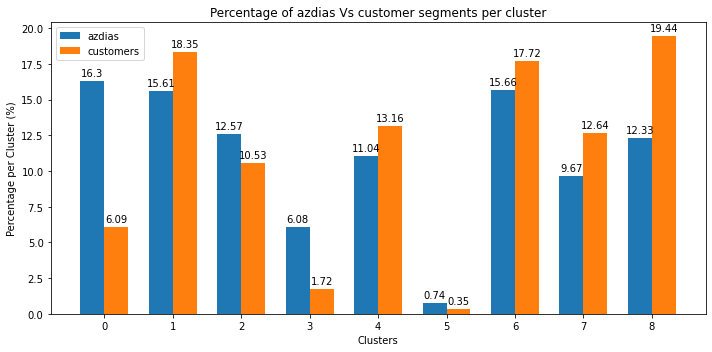

In [ ]:
# Find percentage per cluster
_, uniq_counts_azdias = np.unique(pred_azdias,return_counts=True)
_, uniq_counts_customers = np.unique(pred_customers,return_counts=True)

# plot percentages in clusters in azdias and customers
labels = np.unique(pred_customers).tolist()
per_azdias = np.round((uniq_counts_azdias/len(pred_azdias))*100,2)
per_customers = np.round((uniq_counts_customers/len(pred_customers))*100,2)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, per_azdias, width, label='azdias')
rects2 = ax.bar(x + width/2, per_customers, width, label='customers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage per Cluster (%)')
ax.set_xlabel('Clusters')
ax.set_title('Percentage of azdias Vs customer segments per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

What type of people are presented in clusters 0, 8 and 3 where we notice the biggest differences

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


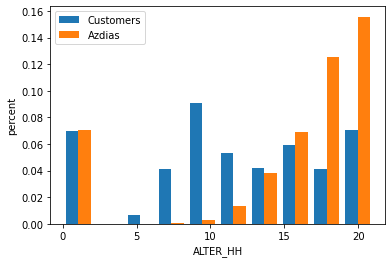

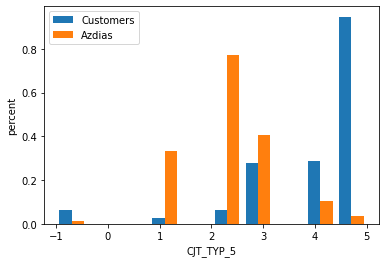

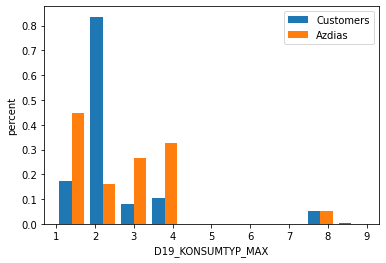

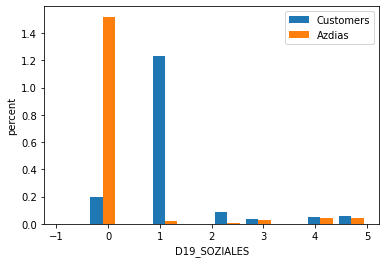

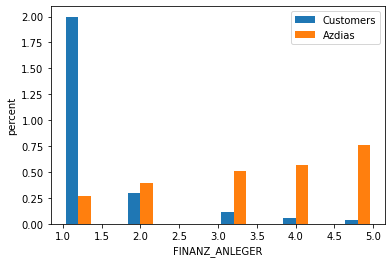

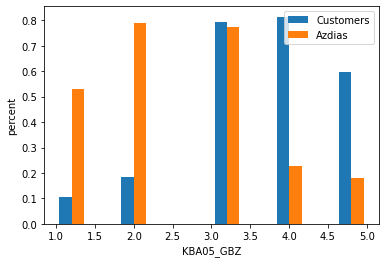

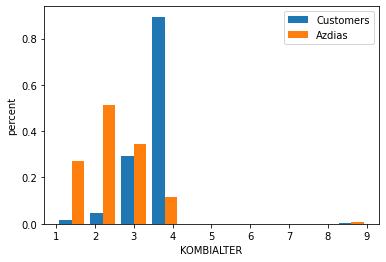

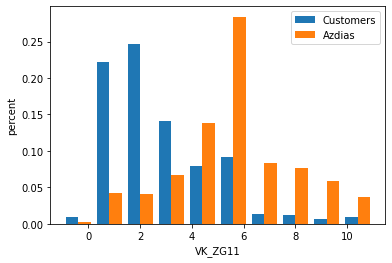

In [ ]:
# As we see in the data visulization part, the distribution of some variable is different 
variables_list=["ALTER_HH","CJT_TYP_5","D19_KONSUMTYP_MAX","D19_SOZIALES",
               "FINANZ_ANLEGER","KBA05_GBZ","KOMBIALTER","VK_ZG11"]

#compare the difference in cluster 7
for col in variables_list:
    Customers_cluster=customers[pred_customers==7]
    Azdias_cluster=azdias[pred_azdias==7]
    plt.hist([Customers_cluster[col],Azdias_cluster[col]],density=1,label=['Customers','Azdias'])
    plt.legend()
    plt.xlabel(col)
    plt.ylabel("percent")
    plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


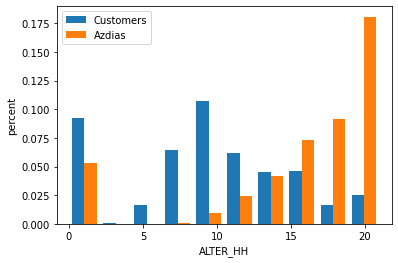

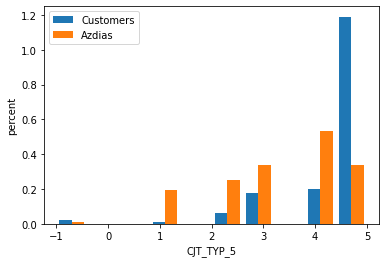

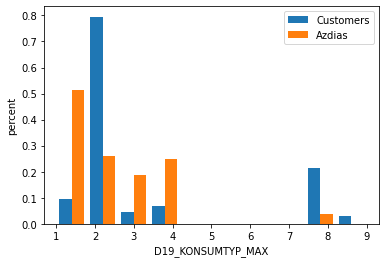

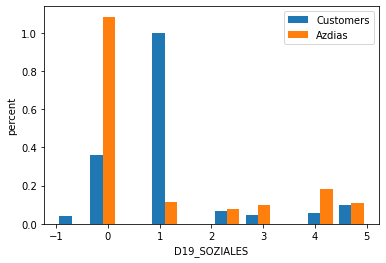

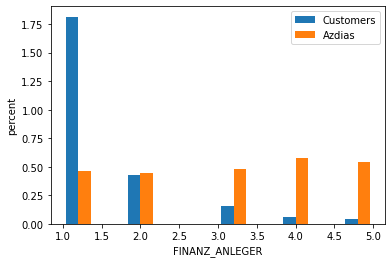

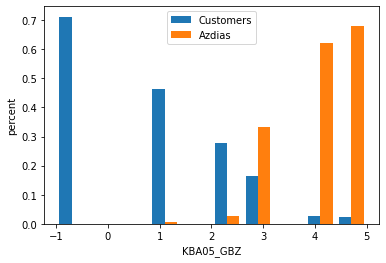

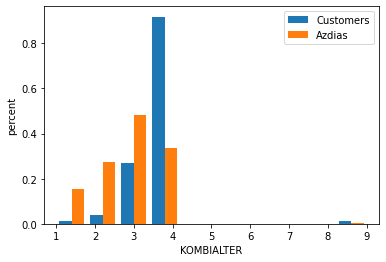

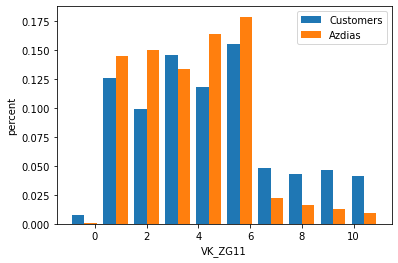

In [ ]:
# As we see in the data visulization part, the distribution of some variable is different 
variables_list=["ALTER_HH","CJT_TYP_5","D19_KONSUMTYP_MAX","D19_SOZIALES",
               "FINANZ_ANLEGER","KBA05_GBZ","KOMBIALTER","VK_ZG11"]

#compare the difference in cluster 0
for col in variables_list:
    Customers_cluster=customers[pred_customers==0]
    Azdias_cluster=azdias[pred_azdias==0]
    plt.hist([Customers_cluster[col],Azdias_cluster[col]],density=1,label=['Customers','Azdias'])
    plt.legend()
    plt.xlabel(col)
    plt.ylabel("percent")
    plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3,0.0,3.0,0.0,1.0,5.0,0.0,10.0,1,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1,0.0,3.0,0.0,3.0,5.0,0.0,5.0,2,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1,0.0,3.0,0.0,2.0,5.0,0.0,4.0,1,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [ ]:
print(f"Shape: {mailout_train.shape}")
mailout_train.head()

Shape: (42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3,0.0,3.0,0.0,1.0,5.0,0.0,10.0,1,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1,0.0,3.0,0.0,3.0,5.0,0.0,5.0,2,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1,0.0,3.0,0.0,2.0,5.0,0.0,4.0,1,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [ ]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [ ]:
mailout_train_cleaned = clean_data(mailout_train)
mailout_train_cleaned = mailout_train.fillna(-1)

Clean dataframe
Remove columns with missing values more than 35%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Remove columns with missing values more than 30%
# of dropped columns: 3
Remove rows with missing values more than 50%


In [ ]:
mailout_train_cleaned = object_type_col(mailout_train_cleaned)

In [ ]:
X = mailout_train_cleaned.drop('RESPONSE',axis=1)
y = mailout_train_cleaned['RESPONSE']

In [ ]:
pickle.dump(X, open("/content/drive/MyDrive/Udacity/Arvato/X.pickle", "wb"))
pickle.dump(y, open("/content/drive/MyDrive/Udacity/Arvato/y.pickle", "wb"))

### Compare different models

In [ ]:
!pip install xgboost
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from tqdm.notebook import tqdm, trange
import time 

In [ ]:
def classifier(clf, X_train=X, y_train=y):
    grid = GridSearchCV(estimator=clf,param_grid={}, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    return grid.best_estimator_

In [ ]:
lg = LogisticRegression(random_state=12) # logistic regression
rf = RandomForestClassifier()# random forest
ADA_Boost = AdaBoostClassifier() # Ada boost
svc = SVC() #Support vector 
xgboost = xgb.XGBClassifier()
lgboost=lgb.LGBMRegressor(boosting_type='gbdt')

Classifiers = [rf, ADA_Boost, svc, xgboost, lgboost]

for i in trange(len(Classifiers)):
    print(classifier(Classifiers[i],X,y))

0.6147312461243436
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.731121740734259
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
0.5224317309915326
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.7639240747

In [ ]:
import pickle
# load pickle objects
X = pickle.load(open("/content/drive/MyDrive/Udacity/Arvato/X.pickle", "rb"))
y = pickle.load(open("/content/drive/MyDrive/Udacity/Arvato/y.pickle", "rb"))

#### Hyperparameter tuning
For Hyperparameter tuning it has been used Bayesian optimization which trains a machine learning model to predict the best hyperparameters. For the Bayesian optimization there are 3 jupyter notebooks for 3 different machine learning models `XGBoost.ipynb` `CatBoost.ipynb`and `LightGBM.ipynb`.

The best score was with Catboost algorithm. The most important features are in the image bellow.
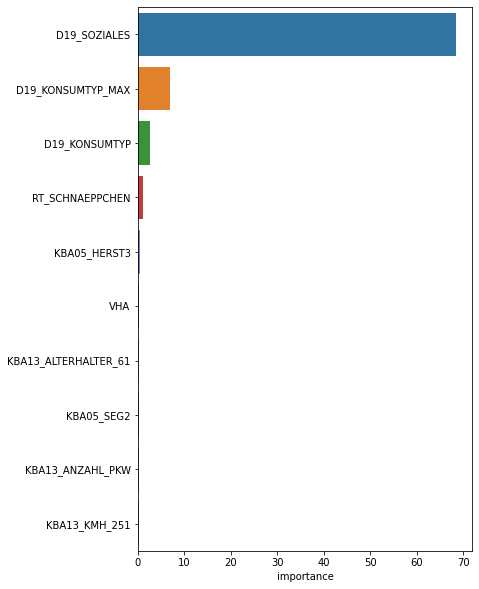

We can notice that the features with D19 at the begging play the most important role in the prediction.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
!pip install catboost
import catboost

# load pickle objects
X_test = pickle.load(open("/content/drive/MyDrive/Udacity/Arvato/X_test.pickle", "rb"))
ctboost = pickle.load(open("/content/drive/MyDrive/Udacity/Arvato/ctboost.pickle", "rb"))

     |████████████████████████████████| 67.3MB 102kB/s 


In [7]:
y_predict = ctboost.predict_proba(X_test)
y_predict[:,1]

array([0.03073097, 0.02976954, 0.00618511, ..., 0.02217921, 0.01867439,
       0.02029818])

In [8]:
mailout_test = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato/Udacity_MAILOUT_052018_TEST.csv', sep=';')

pd.DataFrame(index=mailout_test.LNR, data=y_predict[:, 1], columns=['RESPONSE']).to_csv("kaggle_predictions.txt")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In the kaggle compention I am at the 111 position out of 351 participants.

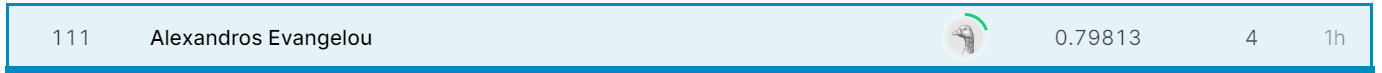